In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle
import random

import warnings
warnings.filterwarnings('ignore')


In [ ]:
import gzip

with gzip.open('/content/drive/MyDrive/DeepFake/new_dataset.pkl.gz', 'rb') as f:
    X, y = pickle.load(f)


In [ ]:
# Create Dataset
D = list(zip(X, y))

In [ ]:
print(D[0])

(array([[[0.13333334, 0.16470589, 0.24705882],
        [0.13333334, 0.16470589, 0.24705882],
        [0.13333334, 0.16470589, 0.24705882],
        ...,
        [0.28627452, 0.1882353 , 0.2627451 ],
        [0.28627452, 0.1882353 , 0.2627451 ],
        [0.28627452, 0.1882353 , 0.2627451 ]],

       [[0.33333334, 0.3647059 , 0.4392157 ],
        [0.33333334, 0.3647059 , 0.4392157 ],
        [0.3254902 , 0.35686275, 0.43137255],
        ...,
        [0.46666667, 0.3372549 , 0.4117647 ],
        [0.46666667, 0.3372549 , 0.4117647 ],
        [0.46666667, 0.3372549 , 0.4117647 ]],

       [[0.28627452, 0.32941177, 0.4       ],
        [0.29411766, 0.3254902 , 0.4       ],
        [0.29803923, 0.32941177, 0.40392157],
        ...,
        [0.48235294, 0.30980393, 0.4       ],
        [0.48235294, 0.30980393, 0.4       ],
        [0.48235294, 0.30980393, 0.4       ]],

       ...,

       [[0.34901962, 0.5372549 , 0.6784314 ],
        [0.34901962, 0.5372549 , 0.6784314 ],
        [0.34901962, 

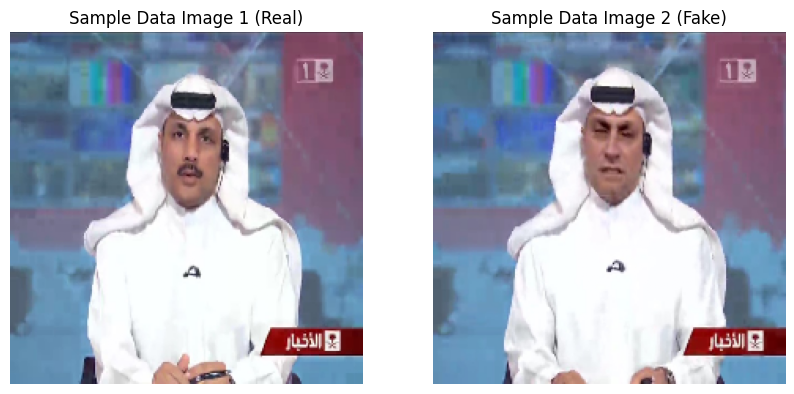

In [ ]:
import matplotlib.pyplot as plt
# Function to plot images in dataset

def plot_images(dataset, title):
    fig, axes = plt.subplots(1, len(dataset), figsize=(5 * len(dataset), 5))
    for i, (img, label) in enumerate(dataset):
        ax = axes[i]
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Hide the axes
        class_label = "Fake" if np.argmax(label) == 1 else "Real"
        ax.set_title(f"{title} Image {i+1} ({class_label})")
    plt.show()
plot_images([D[0],D[10000]],"Sample Data")

In [ ]:
def update_visibility_matrix(v, D, model, sample_size=2000):
        v_new = np.copy(v)  # Copy the current visibility matrix
        sampled_D = random.sample(D, sample_size)  # Random sample from D (without replacement)

        for x, y in sampled_D:
            x = np.expand_dims(x, axis=0)  # Add batch dimension
            y_pred = model.predict(x, verbose=0)[0]  # Predict on x

            true_class = np.argmax(y)
            p = y_pred[true_class]

            # Update v based on loss for the true class
            for i in range(x.shape[1]):
                for j in range(x.shape[2]):
                    loss_v = max(0, 1 - p * y[true_class])
                    v_new[i, j] -= 0.01 * loss_v  # Adjust v using a small learning rate (0.01)

        return np.clip(v_new, 0.5, 1.2)  # Ensure v stays in a reasonable range


In [29]:
def update_visibility_matrix(v, D, model, sample_size=500):
        v_new = np.copy(v)  # Copy the current visibility matrix
        sampled_D = random.sample(D, sample_size)  # Random sample from D (without replacement)

        for x, y in sampled_D:
            x = np.expand_dims(x, axis=0)  # Add batch dimension
            y_pred = model.predict(x, verbose=0)[0]  # Predict on x

            true_class = np.argmax(y)
            p = y_pred[true_class]

            # Update v based on loss for the true class
            for i in range(x.shape[1]):
                for j in range(x.shape[2]):
                    loss_v = max(0, 1 - p * y[true_class])
                    v_new[i, j] -= 0.01 * loss_v  # Adjust v using a small learning rate (0.01)

        return np.clip(v_new, 0.5, 1.2)  # Ensure v stays in a reasonable range


In [ ]:
# Function to create a new dataset Dev with enhanced visibility
def create_dev(D, v):
        Dev = []
        for x, y in D:
            v_x = v * x  # Element-wise multiplication
            Dev.append((v_x, y))
        return Dev

In [ ]:
# Update the visibility matrix
v = np.ones_like(X[0])  # Initialize visibility matrix
print(v.shape)

(224, 224, 3)


In [ ]:
def build_model(input_shape=(224, 224, 3)):

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),  # Input shape is now (3, 3, 3) for RGB images
    tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

# Initialize the model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 2)                 301058    
                                                                 
Total params: 301058 (1.15 MB)
Trainable params: 301058 (1.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Function to train the model on dataset D
def train_model(D, model, epochs=5):
        for epoch in range(epochs):
            total_loss = 0
            for x, y in D:
                x = np.expand_dims(x, axis=0)  # Add batch dimension
                y = np.expand_dims(y, axis=0)  # Add batch dimension

                # Train on batch
                loss = model.train_on_batch(x, y)
                total_loss += loss
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(D):.4f}')

In [21]:
# Initial Training on Dataset D
print("Initial Training on Dataset D:")
train_model(D, model)


Initial Training on Dataset D:
Epoch [1/5], Loss: 0.0849
Epoch [2/5], Loss: 5.4083
Epoch [3/5], Loss: 7.1624
Epoch [4/5], Loss: 7.1619
Epoch [5/5], Loss: 7.1613


In [ ]:
# Update the visibility matrix after the first iteration
print("\nUpdating visibility matrix after iteration 1:")
v = update_visibility_matrix(v, D, model)
print(f"Updated Visibility Matrix v:\n{v}")

In [24]:
# Create new dataset Dev with enhanced visibility
Dev = create_dev(D, v)
print("Enhanced dataset created for iteration 1")

Enhanced dataset created for iteration 1


In [25]:
import os

# Change to a new directory
os.chdir('/content/drive/MyDrive/DeepFake')

# Verify the current working directory
print(os.getcwd())


/content/drive/MyDrive/DeepFake


In [26]:
import pickle
import gzip

# Compress and save the file with gzip
with gzip.open('enhanced_dataset_1.pkl.gz', 'wb') as f:
      pickle.dump(Dev, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")

Done


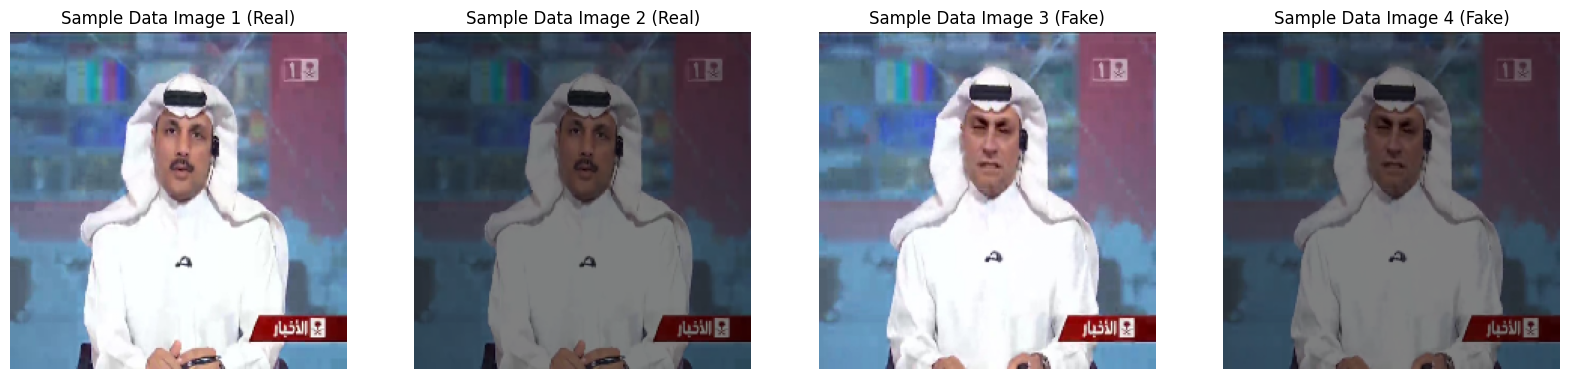

In [27]:
# Function to plot images in dataset
def plot_images(dataset, title):
    fig, axes = plt.subplots(1, len(dataset), figsize=(5 * len(dataset), 5))
    for i, (img, label) in enumerate(dataset):
        ax = axes[i]
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Hide the axes
        class_label = "Fake" if np.argmax(label) == 1 else "Real"
        ax.set_title(f"{title} Image {i+1} ({class_label})")
    plt.show()
plot_images([D[0],Dev[0],D[10000],Dev[10000]],"Sample Data")

In [28]:
# Retrain the model on the new dataset Dev
print("\nRetraining on Dataset Dev:")
train_model(Dev, model, epochs=5)


Retraining on Dataset Dev:
Epoch [1/5], Loss: 3.5800
Epoch [2/5], Loss: 3.5802
Epoch [3/5], Loss: 3.5799
Epoch [4/5], Loss: 3.5797
Epoch [5/5], Loss: 3.5795


In [ ]:
# Update the visibility matrix again (second iteration)
print("\nUpdating visibility matrix after iteration 2:")
v = update_visibility_matrix(v, D, model)
print(f"Updated Visibility Matrix v:\n{v}")

In [31]:
# Create new dataset Dev with enhanced visibility
Dev = create_dev(D, v)
print("Enhanced dataset created for iteration 2")

Enhanced dataset created for iteration 2


In [32]:
import pickle
import gzip

# Compress and save the file with gzip
with gzip.open('enhanced_dataset_2.pkl.gz', 'wb') as f:
      pickle.dump(Dev, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")

Done


In [33]:
# Saving the TensorFlow model
model.save('model_new.h5')
model.save('model_new.keras')# Saving the visibility matrix
np.save('visibility_matrix_new.npy', v)


In [34]:
# Retrain the model on the new dataset Dev
print("\nRetraining on Dataset Dev after second iteration:")
train_model(Dev, model, epochs=5)



Retraining on Dataset Dev after second iteration:
Epoch [1/5], Loss: 3.8444
Epoch [2/5], Loss: 3.8453
Epoch [3/5], Loss: 3.8451
Epoch [4/5], Loss: 3.8449
Epoch [5/5], Loss: 3.8447


In [35]:
# Saving the TensorFlow model
model.save('model_new2.h5')
model.save('model_new2.keras')# Saving the visibility matrix
np.save('visibility_matrix_new2.npy', v)


In [36]:
print(Dev[0])

(array([[[0.06666667, 0.08235294, 0.12352941],
        [0.06666667, 0.08235294, 0.12352941],
        [0.06666667, 0.08235294, 0.12352941],
        ...,
        [0.14313726, 0.09411765, 0.13137256],
        [0.14313726, 0.09411765, 0.13137256],
        [0.14313726, 0.09411765, 0.13137256]],

       [[0.16666667, 0.18235295, 0.21960784],
        [0.16666667, 0.18235295, 0.21960784],
        [0.1627451 , 0.17843138, 0.21568628],
        ...,
        [0.23333333, 0.16862746, 0.20588236],
        [0.23333333, 0.16862746, 0.20588236],
        [0.23333333, 0.16862746, 0.20588236]],

       [[0.14313726, 0.16470589, 0.2       ],
        [0.14705883, 0.1627451 , 0.2       ],
        [0.14901961, 0.16470589, 0.20196079],
        ...,
        [0.24117647, 0.15490197, 0.2       ],
        [0.24117647, 0.15490197, 0.2       ],
        [0.24117647, 0.15490197, 0.2       ]],

       ...,

       [[0.17450981, 0.26862746, 0.3392157 ],
        [0.17450981, 0.26862746, 0.3392157 ],
        [0.17450981, 

In [37]:
print(D[0])  

(array([[[0.13333334, 0.16470589, 0.24705882],
        [0.13333334, 0.16470589, 0.24705882],
        [0.13333334, 0.16470589, 0.24705882],
        ...,
        [0.28627452, 0.1882353 , 0.2627451 ],
        [0.28627452, 0.1882353 , 0.2627451 ],
        [0.28627452, 0.1882353 , 0.2627451 ]],

       [[0.33333334, 0.3647059 , 0.4392157 ],
        [0.33333334, 0.3647059 , 0.4392157 ],
        [0.3254902 , 0.35686275, 0.43137255],
        ...,
        [0.46666667, 0.3372549 , 0.4117647 ],
        [0.46666667, 0.3372549 , 0.4117647 ],
        [0.46666667, 0.3372549 , 0.4117647 ]],

       [[0.28627452, 0.32941177, 0.4       ],
        [0.29411766, 0.3254902 , 0.4       ],
        [0.29803923, 0.32941177, 0.40392157],
        ...,
        [0.48235294, 0.30980393, 0.4       ],
        [0.48235294, 0.30980393, 0.4       ],
        [0.48235294, 0.30980393, 0.4       ]],

       ...,

       [[0.34901962, 0.5372549 , 0.6784314 ],
        [0.34901962, 0.5372549 , 0.6784314 ],
        [0.34901962, 

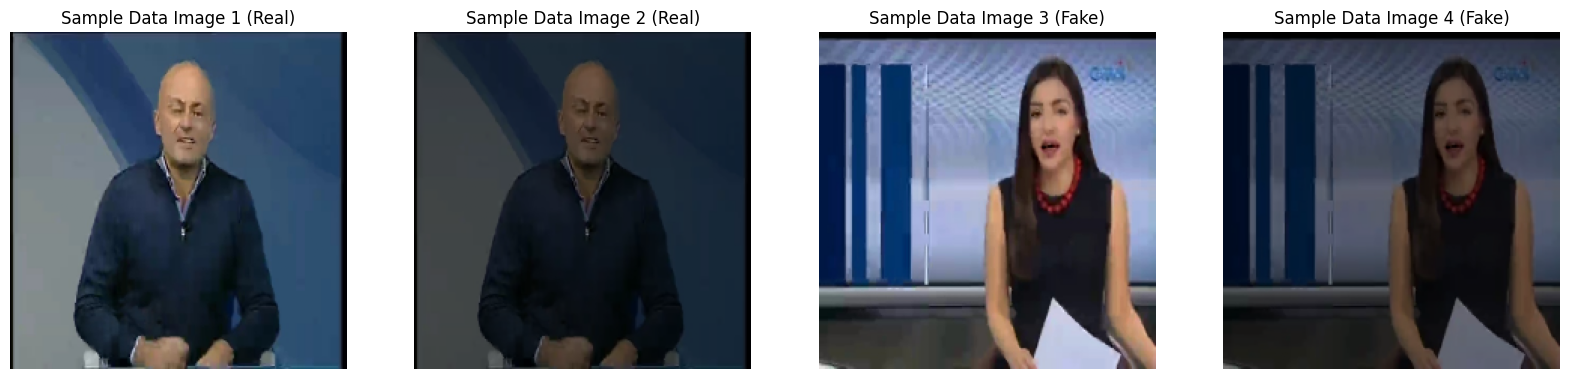

In [38]:
plot_images([D[32],Dev[32],D[10123],Dev[10123]],"Sample Data")

In [45]:
img = '/content/011_805_key_frame_5.jpg'
img = load_img(img, target_size=(224, 224))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
print(img.shape)
model.predict(img)

(1, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step


array([[0., 1.]], dtype=float32)

In [64]:
img = '/content/000_003_key_frame_0.jpg'
img = load_img(img, target_size=(224, 224))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
model.predict(img)

1/1 [==============================] - 0s 23ms/step


array([[0., 1.]], dtype=float32)